In [1]:
# test autoencoders
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
#import shap

2023-08-17 16:55:27.889542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
type(x_train)
x_train.shape

(1000, 784)

In [2]:
# Load and preprocess the FashionMNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# subset of data
x_train = x_train[0:1000,:,:]
y_train = y_train[0:1000]
x_test = x_test[0:50,:,:]
y_test = y_test[0:50]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



In [4]:
# build an autoencoder
# Define the dimensions
input_dim = x_train.shape[1]
latent_dim = 32

# Build the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder1 = Dense(256, activation='relu')(input_layer)
encoder2 = Dense(128, activation='relu')(encoder1)
encoder3 = Dense(64, activation='relu')(encoder2)
encoder4 = Dense(latent_dim, activation='relu')(encoder3)

decoder1 = Dense(64, activation='relu')(encoder4)
decoder2 = Dense(128, activation='relu')(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)
decoder4 = Dense(input_dim, activation='sigmoid')(decoder3)

autoencoder = Model(inputs = input_layer, outputs = decoder4)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print the model info
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(x_train, x_train, # from x_train to x_train
                epochs=20, # number of times the entire dataset will be iterated through during training
                batch_size=100, # the number of samples that will be used in each update of the model's weights.
                shuffle=True, #  the training data will be shuffled before each epoch
                validation_data=(x_test, x_test))


decoded_imgs = autoencoder.predict(x_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

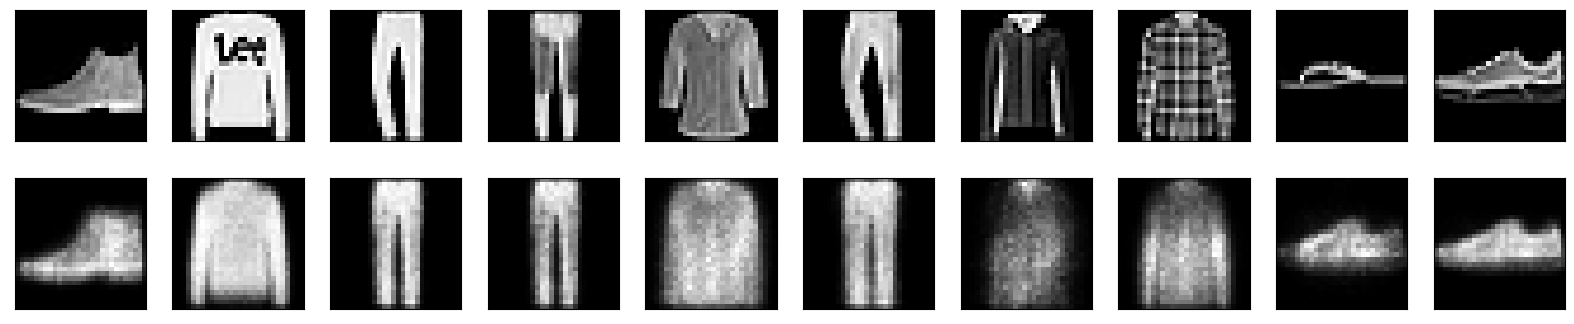

In [6]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [7]:
# extract latent representation
# Assuming 'autoencoder' is your trained autoencoder model
encoder_model = Model(inputs=input_layer, outputs=encoder4)

# Get latent features using the encoder model
latent_features_train = encoder_model.predict(x_train)
latent_features_test = encoder_model.predict(x_test)


2/2 [==============================] - 0s 9ms/step


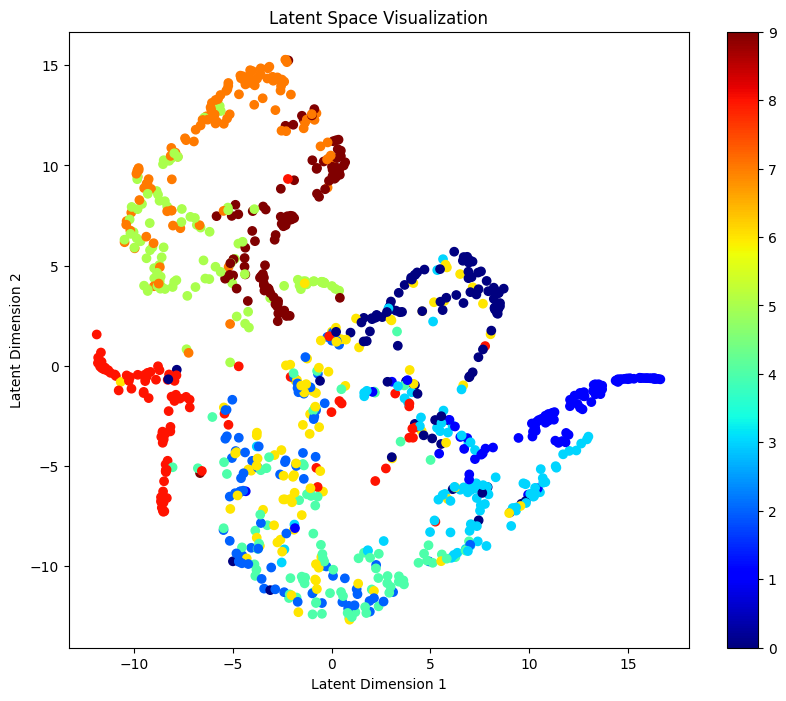

In [22]:
# Visualize the latent space using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_tsne = tsne.fit_transform(latent_features_train)

plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=y_train, cmap='jet')
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()


In [34]:
# estimate the feature weights using shap

# Initialize SHAP explainer
explainer = shap.Explainer(autoencoder, x_train)

# Explain a specific instance using SHAP

sample = x_train[0,:]

shap_values = explainer.shap_values(x_test)

# Visualize the SHAP values
shap.image_plot(shap_values[0].reshape(28, 28), -sample.reshape(28, 28))

Permutation explainer: 51it [22:22, 26.86s/it]                        


ValueError: cannot reshape array of size 614656 into shape (28,28)

In [31]:
sample.shape

(784,)